In [1]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

print(tf.__version__)
print('TensorFlow version:',tf.__version__)
print('Keras version:',tf.keras.__version__)

2.4.1
TensorFlow version: 2.4.1
Keras version: 2.4.0


In [2]:
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [6]:
classes = pd.read_csv("data/Train.csv")

min_width, max_width = max(classes.Width), min(classes.Width)
min_height, max_height = max(classes.Height), min(classes.Height)

print(np.mean([min_width, max_width]))
print(np.mean([min_height, max_height]))

134.0
125.0


In [7]:
classes_no = len(classes.ClassId.unique())
print("There are {} unique classes in the dataset.".format(classes_no))

There are 43 unique classes in the dataset.


Load the data and use data augmentation

In [8]:
cwd = os.getcwd()
base_dir = os.path.join(cwd, 'data')
train_path= os.path.join(base_dir, 'Train')
test_path= os.path.join(base_dir, 'Test')

In [9]:
BATCH_SIZE = 150
STEPS_PER_EPOCH = 2000
TARGET_SIZE = (32, 32)

In [10]:
# Create a data generator for the training images
train_datagen = ImageDataGenerator(
                                rescale=1./255,
                                rotation_range=10,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                zoom_range=0.2,
                                validation_split=0.2)  # val 20%

# Create a data generator for the validation images
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

#Split data to training and validation datasets
train_data = train_datagen.flow_from_directory(train_path, 
                                               target_size=TARGET_SIZE, 
                                               color_mode='grayscale',
                                               batch_size=BATCH_SIZE, 
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=2,
                                               subset = 'training') 

val_data = val_datagen.flow_from_directory(train_path, 
                                           target_size=TARGET_SIZE, 
                                           color_mode='grayscale',
                                           batch_size=BATCH_SIZE, 
                                           class_mode='categorical',
                                           shuffle=False,
                                           seed=2,
                                           subset = 'validation')

datagen = ImageDataGenerator(rescale=1./255)
test_data = datagen.flow_from_directory(test_path,
                                        target_size=TARGET_SIZE, 
                                        color_mode='grayscale',
                                        class_mode='categorical',
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True)

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.
Found 12630 images belonging to 43 classes.


In [11]:
X_batch, y_batch = next(train_data, 15)

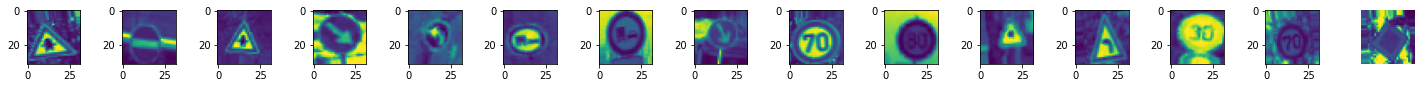

In [9]:
fig, ax = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
    ax[i].imshow(X_batch[i].reshape(32, 32))
    plt.axis("off")

In [10]:
ACCURACY_THRESHOLD = 0.98

class myCallback(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > ACCURACY_THRESHOLD):
            print("\nReached 98% accuracy so cancelling training!")
            self.model.stop_training = True

callback = myCallback()

LeNEt 5 model    

In [11]:
def leNet():
    
    filters_no=60
    filter_size=(5,5)
    filter_size2=(3,3)
    size_of_pool=(2,2)
    no_of_nodes=500

    model = tf.keras.Sequential()

    model.add(layers.Conv2D(filters=filters_no, kernel_size=filter_size, activation='relu', input_shape=(32, 32, 1)))
    
    model.add(layers.Conv2D(filters=filters_no, kernel_size=filter_size, activation='relu'))
    
    model.add(layers.MaxPooling2D(pool_size=size_of_pool))

    model.add(layers.Conv2D(filters=filters_no//2, kernel_size=filter_size2, activation='relu'))
    
    model.add(layers.Conv2D(filters=filters_no//2, kernel_size=filter_size2, activation='relu'))

    model.add(layers.MaxPooling2D(pool_size=size_of_pool))

    model.add(layers.Dropout(0.5))

    model.add(layers.Flatten())

    model.add(layers.Dense(units=no_of_nodes, activation='relu'))

    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(units=classes_no, activation = 'softmax'))
    
    return model

In [84]:
from tensorflow.keras.optimizers import Adam

lenet = leNet()
lenet.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
lenet.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 4, 30)         

In [92]:
start_time = datetime.datetime.now()
print(start_time)

2021-04-07 08:52:39.408507


In [93]:
history = lenet.fit(
      train_data,
      steps_per_epoch= train_data.samples // BATCH_SIZE,  # One pass through entire training dataset
      epochs=200,
      validation_data=val_data,
      validation_steps= val_data.samples // BATCH_SIZE,  # One pass through entire validation dataset
      callbacks=[callback],
      verbose=1)

Epoch 1/200
209/209 [==============================] - 66s 315ms/step - loss: 3.4494 - accuracy: 0.0842 - val_loss: 3.1518 - val_accuracy: 0.2129
Epoch 2/200
209/209 [==============================] - 24s 115ms/step - loss: 2.9916 - accuracy: 0.2031 - val_loss: 2.3955 - val_accuracy: 0.3574
Epoch 3/200
209/209 [==============================] - 23s 111ms/step - loss: 2.5577 - accuracy: 0.2984 - val_loss: 1.9237 - val_accuracy: 0.4515
Epoch 4/200
209/209 [==============================] - 25s 122ms/step - loss: 2.2513 - accuracy: 0.3704 - val_loss: 1.5981 - val_accuracy: 0.5240
Epoch 5/200
209/209 [==============================] - 23s 112ms/step - loss: 2.0171 - accuracy: 0.4303 - val_loss: 1.3282 - val_accuracy: 0.6195
Epoch 6/200
209/209 [==============================] - 23s 110ms/step - loss: 1.8334 - accuracy: 0.4735 - val_loss: 1.1667 - val_accuracy: 0.6700
Epoch 7/200
209/209 [==============================] - 24s 113ms/step - loss: 1.6750 - accuracy: 0.5081 - val_loss: 1.0187 -

In [94]:
end_time = datetime.datetime.now()
print(end_time)

duration = end_time - start_time
print(duration)

2021-04-07 10:21:56.799402
1:29:17.390895


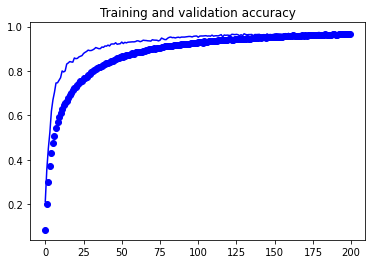

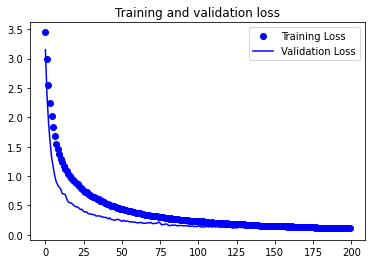

In [96]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [95]:
lenet.save('trained_model/lenet_acc96') 

INFO:tensorflow:Assets written to: trained_model/lenet_acc96\assets


### Load saved model

In [3]:
cwd = os.getcwd()
model_path = os.path.join(cwd, "trained_model/lenet_acc96")
lenet = tf.keras.models.load_model(model_path)

In [12]:
results = lenet.evaluate(test_data, batch_size=20)

85/85 [==============================] - 105s 1s/step - loss: 0.1366 - accuracy: 0.9643


In [103]:
X_test_batch, y_test_batch = next(test_data, 15)

In [104]:
predictions = np.argmax(lenet.predict(X_test_batch, steps=1), axis=1)

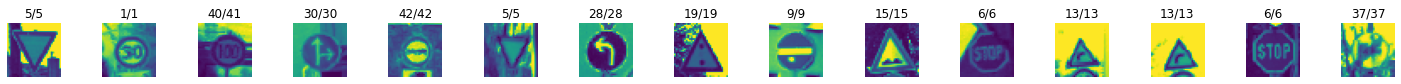

In [105]:
fig, ax = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
    ax[i].imshow(X_test_batch[i].reshape(32, 32))
    ax[i].set_title(str(np.argmax(y_test_batch[i])) + "/" + str(predictions[i]))
    ax[i].axis("off")

In [79]:
signs = {}

signs_path = os.path.join(cwd, 'data\Meta')

for i, img_name in enumerate(os.listdir(signs_path)):
    img_path = os.path.join(signs_path, img_name)
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(500, 500))
    signs[i] = img

In [80]:
sample_images = {}
sample_images_array = {}

signs_sample_path = os.path.join(cwd, 'sample_photos')

for i, img_name in enumerate(os.listdir(signs_sample_path)):
    if not img_name.endswith('.ipynb_checkpoints'):
        img_path = os.path.join(signs_sample_path, img_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(32, 32), color_mode="grayscale")
        
        x = tf.keras.preprocessing.image.img_to_array(img)
        x = np.expand_dims(x, axis=0)  # Add a unit dimension at the front
        
        sample_images_array[img_name.split('.')[0]] = x
        sample_images[img_name.split('.')[0]] = img


In [81]:
for name, sample in sample_images_array.items():
    prediction = np.argmax(lenet.predict(sample, steps=1), axis=1)
    print(name, ":", prediction[0])

sample_1 : 15
sample_10 : 35
sample_10a : 3
sample_2 : 5
sample_3 : 1
sample_4 : 32
sample_4a : 6
sample_5 : 3
sample_7 : 21
sample_8 : 1
sample_8a : 12
sample_9 : 6


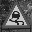

In [82]:
sample_images["sample_10a"]

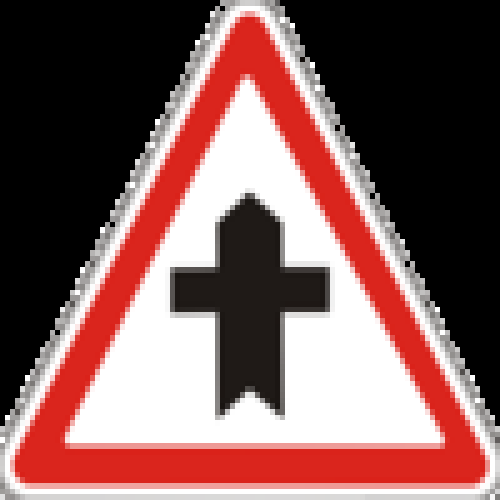

In [83]:
signs[3]